* **Nama : Brilly Lutfan Qasthari**
* **Email : brilly.lutfan@gmail.com**
* **Alamat : Yogyakarta**



In [ ]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten, Embedding, Reshape
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm
import plotly.express as px

plt.rcParams['font.size'] =  12

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"brillyskripsi","key":"2fe52460b9aa64f09bb59e1efae7840c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

100% 1.76G/1.76G [00:40<00:00, 68.6MB/s]
100% 1.76G/1.76G [00:40<00:00, 46.1MB/s]


In [ ]:
!unzip -qq lung-and-colon-cancer-histopathological-images.zip -d dataset

In [ ]:
!mkdir ./LungColon

print('Copying files...')
!cp -R /content/dataset/lung_colon_image_set/colon_image_sets/* ./LungColon
!cp -R /content/dataset/lung_colon_image_set/lung_image_sets/* ./LungColon
print('All files copied successfully!')

Copying files...
All files copied successfully!


In [ ]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

splitfolders.ratio('/content/LungColon', '/content/dataset2', seed=1, ratio=(.8, .2))

Copying files: 25000 files [00:07, 3126.94 files/s]


In [ ]:
train_dir = '/content/dataset2/train'
test_dir = '/content/dataset2/val'

In [ ]:
import os

training_data = []
test_data = []
labels = os.listdir(train_dir)
for folder in os.listdir(train_dir):
    training_data.append(len(os.listdir(os.path.join(train_dir,folder))))
    
for folder in os.listdir(test_dir):
    test_data.append(len(os.listdir(os.path.join(test_dir,folder))))

In [ ]:
fig = px.bar(x=labels, y=training_data, title='Jumlah Kelas Training Data')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

In [ ]:
fig = px.bar(x=labels, y=test_data, title='Jumlah Kelas Testing Data')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

In [ ]:
batch_size = 128
img_size = 224

datagen = ImageDataGenerator(rescale=1/255.,
                             zoom_range=0.2,
                             horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = datagen.flow_from_directory(train_dir,  
                                                target_size=(img_size, img_size), 
                                                batch_size=batch_size,
                                                classes=['lung_n', 'lung_aca', 'colon_n', 'lung_scc', 'colon_aca'],
                                                shuffle=True,
                                                subset='training',
                                                class_mode='categorical')  

validation_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    classes=['lung_n', 'lung_aca', 'colon_n', 'lung_scc', 'colon_aca'],
                                                    shuffle=False,
                                                    subset='validation',
                                                    class_mode='categorical')

Found 20000 images belonging to 5 classes.
Found 0 images belonging to 5 classes.


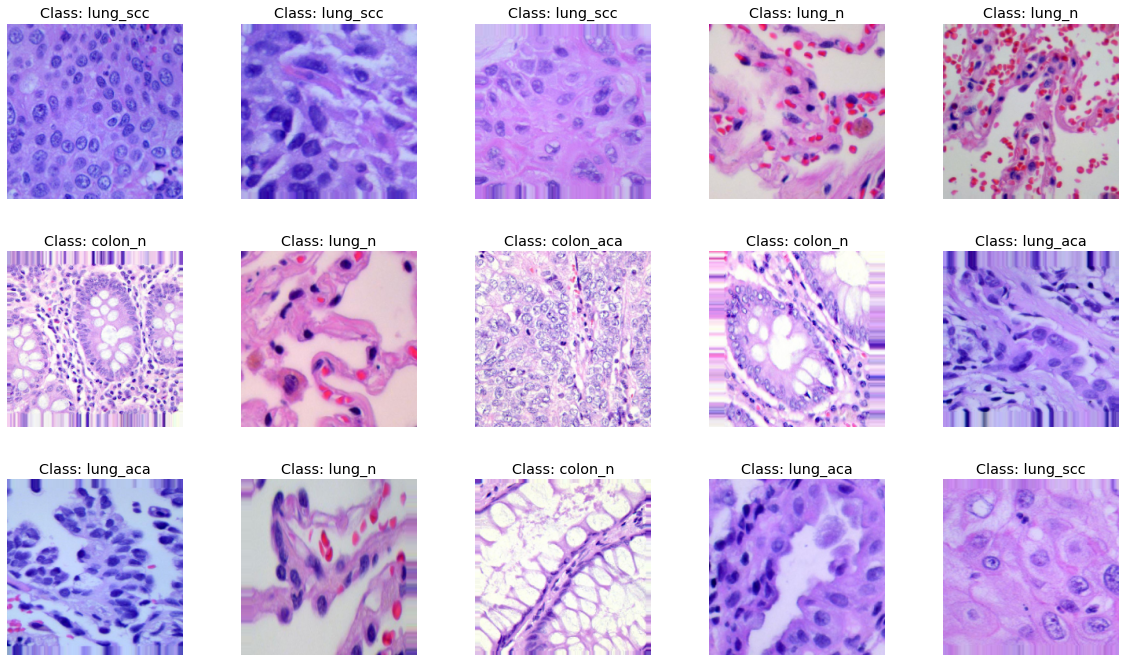

In [ ]:
labels = [k for k,v in train_generator.class_indices.items()]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

In [ ]:
from tensorflow.keras.applications import ResNet152V2

model = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3))),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(5, activation='softmax')  
])
model.layers[0].trainable = False

234545216/234545216 [==============================] - 6s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 128)         2359424   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [ ]:
len(model.layers)

8

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
model_name = "model_submission_final_dicoding.hdf5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.00000001)

In [ ]:
history = model.fit(train_generator,
                    epochs=3,
                    validation_data=validation_generator,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/3
157/157 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9836
Epoch 1: val_loss did not improve from 0.04689
157/157 [==============================] - 418s 3s/step - loss: 0.0472 - accuracy: 0.9836 - val_loss: 16.8424 - val_accuracy: 6.0000e-04 - lr: 1.0000e-04
Epoch 2/3
  8/157 [>.............................] - ETA: 5:37 - loss: 0.0386 - accuracy: 0.9854

KeyboardInterrupt: ignored

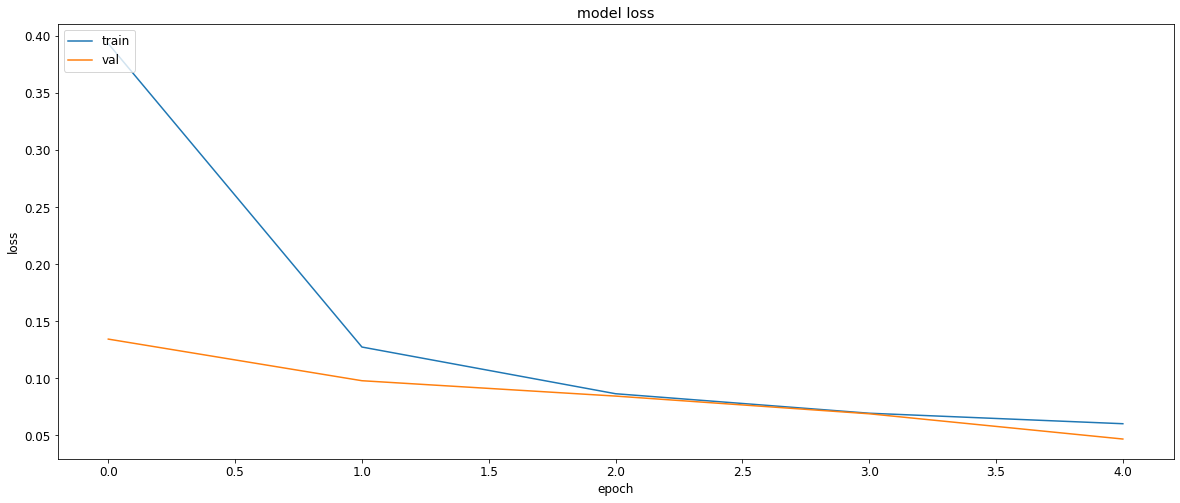

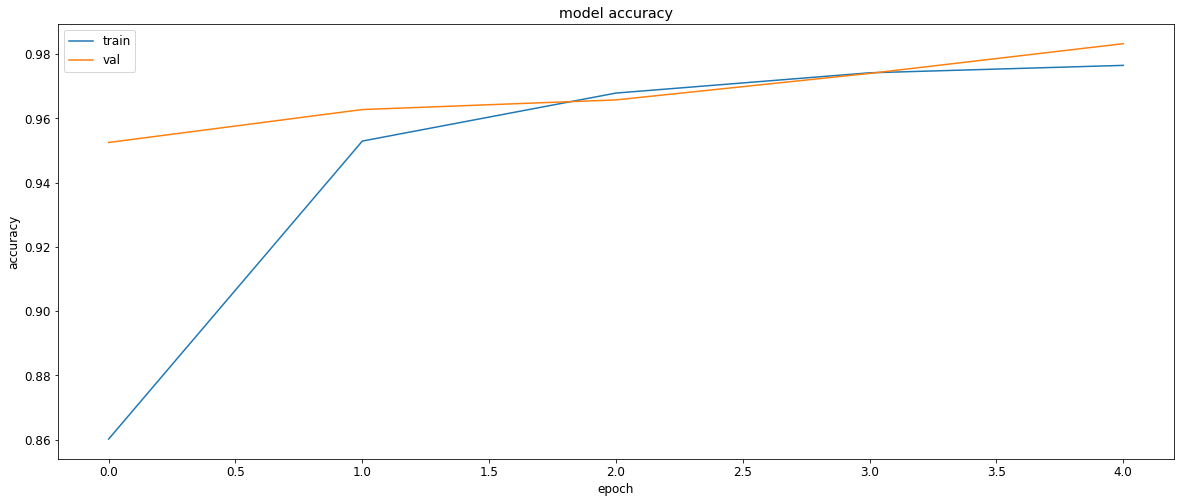

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!ls -la | grep 'model'

-rw-r--r-- 1 root root  267344432 Oct 31 13:55 model_submission_final_dicoding.hdf5
-rw-r--r-- 1 root root  243834908 Oct 31 13:59 model.tflite
